<h1> Machine Learning Algorithms and their workings </h1>

In [58]:
#standard imports
import numpy as np
import pandas as pd
import os
from scipy import signal
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
import mglearn
#generate dataset
def make_forge():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y
X, y = make_forge();

<ipython-input-58-826857a55c77>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones(len(X), dtype=np.bool)


In [18]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

X shape: (26, 2)


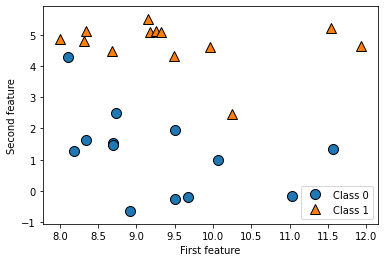

In [20]:
discrete_scatter(X[:, 0], X[:,1], y)
plt.legend(["Class 0", "Class 1"], loc = 4)
plt.xlabel("First feature")
plt.ylabel("Second feature")
print(f"X shape: {X.shape}")

In [21]:
#make waves dataset
def make_wave(n_samples=100):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (np.sin(4 * x) + x)
    y = (y_no_noise + rnd.normal(size=len(x))) / 2
    return x.reshape(-1, 1), y

Text(0, 0.5, 'Target')

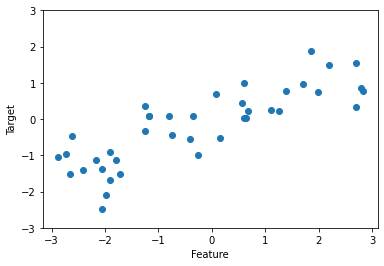

In [22]:
X,y = make_wave(n_samples = 40)
plt.plot(X,y,'o')
plt.ylim(-3,3)
plt.xlabel("Feature")
plt.ylabel("Target")

<h2> Breast Cancer prediction </h2>

In [24]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print(f'cancer.keys() \n {cancer.keys()}')

cancer.keys() 
 dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [25]:
#inspect the dataset
print(f'Shape of cancer data: {cancer.data.shape}')

Shape of cancer data: (569, 30)


In [32]:
#569 data points with 30 features each
print("Sample counts per class \n {}".format(
    {n: v for n, v in zip(cancer.target_names,np.bincount(cancer.target))}))

Sample counts per class 
 {'malignant': 212, 'benign': 357}


In [33]:
#description of semantic meaning of each feature
print(f"Feature names : \n {cancer.feature_names}")

Feature names : 
 ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [37]:
from sklearn.model_selection import train_test_split
X, y = make_forge()
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

<ipython-input-17-8358f047e9b7>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones(len(X), dtype=np.bool)


In [48]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)

In [49]:
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [50]:
print(f"Test set predicitions : {clf.predict(X_test)}")

Test set predicitions : [1 0 1 0 1 0 0]


In [54]:
print(f"Test set accuracy : {clf.score(X_test,y_test):.2f}")
cm2 = ListedColormap(['#0000aa', '#ff2020'])


Test set accuracy : 1.00


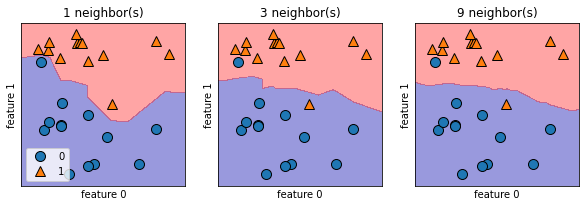

In [62]:
#Visualization of decision boundaries for one, three and nine neighbors
%matplotlib inline

fig,axes = plt.subplots(1,3,figsize=(10,3))
for n_neighbors, ax in zip([1,3,9], axes):
    #the fit method returns the object self, so we can instantiate
    #and fit in one line
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X,y)
    mglearn.plots.plot_2d_separator(clf, X , fill=True, eps = 0.5, ax =ax,alpha=.4)
    mglearn.discrete_scatter(X[:,0], X[:,1], y, ax=ax)
    ax.set_title(f"{n_neighbors} neighbor(s)")
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1")
axes[0].legend(loc=3);